# Create Dataset

Now that we have explored face detection and deep fake prediction on small datasets, let's try to create a 
balanced dataset on which we can train competitive networks for this competition.

We'll start by loading all of the `metadata.json` files.

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

from pathlib import Path
from tqdm.notebook import tqdm

from utils import nms, read_all_frames, plot_detections, get_video_stats, read_random_frames
from EasyBlazeFace import EasyBlazeFace

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

### Load Data

In [2]:
def load_all_metadata():
    # Join metadata files into single dataframe
    metadata_list = []

    for i in tqdm(range(50)):
        folder = Path("../data/dfdc_train_part_" + str(i))
        metadata_file_path = folder/'metadata.json'
        metadata = pd.read_json(metadata_file_path).T

        metadata.reset_index(inplace=True)
        metadata.rename({'index':'fname'}, axis=1, inplace=True)

        metadata['directory'] =  str(folder) 

        metadata_list.append(metadata)


    all_metadata = pd.concat(metadata_list)
    return all_metadata

In [3]:
all_metadata = load_all_metadata()

In [4]:
all_metadata.head()

,fname,label,split,original,directory
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,../data/dfdc_train_part_0
1,vpmyeepbep.mp4,REAL,train,NaN,../data/dfdc_train_part_0
2,fzvpbrzssi.mp4,REAL,train,NaN,../data/dfdc_train_part_0
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,../data/dfdc_train_part_0
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,../data/dfdc_train_part_0


In [5]:
print("There are {} unique files".format(len(all_metadata)))

There are 119154 unique files


In [6]:
real_files = all_metadata.loc[all_metadata['label'] == 'REAL']

In [7]:
print("There are {} original/real files".format(len(real_files)))

There are 19154 original/real files


In [ ]:
original_to_fake_lookup = {}

for i, row in tqdm(real_files.iterrows()):

    # Get the current "REAL" filename
    fname = row['fname']
    # Find all fakes that have this filename marked as their ORIGINAL
    fake_files = all_metadata.loc[all_metadata['original'] == fname]
    
    # Map from original fname to all the fake filenames
    original_to_fake_lookup[fname] = list(fake_files['fname'])
    
np.save('original_to_fake_lookup.npy', np.array(original_to_fake_lookupinal_to_fake_lookup))

In [8]:
x = np.load('original_to_fake_lookup.npy', allow_pickle=True)
original_to_fake_lookup = x.item()

## Imbalances in People Represented in Videos

We do not want to overrepresent certain people within our dataset. Some folders contain almost exclusively one person and we should be careful to remove them. We could consider using them in our validation dataset.

#### Folders to consider

- `dfdc_train_part_0` (1300)
 - contains only one person in all but two videos
- `dfdc_train_part_1` (1700)
 - contains only one person in most (>90%) of videos
- `dfdc_train_part_2` (1749)
 -  Good!
- `dfdc_train_part_3` (1456)
 - One woman appears a little more frequently. She's also not deep faked properly.
- `dfdc_train_part_4` (1702)
 - One woman appears a little more frequently.
- `dfdc_train_part_5` (2484)
 - One man appears very frequently (>90%) of videos
- `dfdc_train_part_6` (3465)
 - One woman in ~50% of videos
- `dfdc_train_part_7` (2474)
 - Roughly balanced, maybe one guy slightly over represented
- `dfdc_train_part_8` (1817)
 - Good
- `dfdc_train_part_9` (1737)
 - Good
- `dfdc_train_part_10` (3193)
 - One woman may be over represented ~40%
- `dfdc_train_part_11` (2119)
 - Good
- `dfdc_train_part_12` (2226)
 - Good
- `dfdc_train_part_13` (3695)
 - One woman may be over represented ~40%
- `dfdc_train_part_14` (2465)
 - One guy is over represented (50%) of videos
- `dfdc_train_part_15` (2274)
 - Good
- `dfdc_train_part_16` (2062)
 - Good
- `dfdc_train_part_17` (2431) 
 - Good
- `dfdc_train_part_18` (2684) 
 - Good
- `dfdc_train_part_19` (2573) 
 - Good
- `dfdc_train_part_20` (2515) 
 - Good
- `dfdc_train_part_21` (2269) 
 - Good
- `dfdc_train_part_22` (2410) 
 - Good
- `dfdc_train_part_23` (2411) 
 - Good
- `dfdc_train_part_24` (2787) 
 - Good
- `dfdc_train_part_25` (2547) 
 - Good but maybe one guy shows up a little more
- `dfdc_train_part_26` (2434) 
 - Good but maybe one guy shows up a little more
- `dfdc_train_part_27` (2354) 
 - Good but maybe one woman shows up a little more
- `dfdc_train_part_28` (2086) 
 - Good
- `dfdc_train_part_29` (2558) 
 - Good
- `dfdc_train_part_30` (2337) 
 - Good
- `dfdc_train_part_31` (2471) 
 - Good
- `dfdc_train_part_32` (2357) 
 - Good
- `dfdc_train_part_33` (2275) 
 - Good
- `dfdc_train_part_34` (2659) 
 - Good
- `dfdc_train_part_35` (2536) 
 - Good
- `dfdc_train_part_36` (2340) 
 - Good
- `dfdc_train_part_37` (2656) 
 - Good
- `dfdc_train_part_38` (2478) 
 - Good
- `dfdc_train_part_39` (2557) 
 - Good
- `dfdc_train_part_40` (2421) 
 - Good
- `dfdc_train_part_41` (2223) 
 - Good
- `dfdc_train_part_42` (2385) 
 - Good
- `dfdc_train_part_43` (2547) 
 - Good
- `dfdc_train_part_44` (2666) 
 - Good
- `dfdc_train_part_45` (2347) 
 - Good
- `dfdc_train_part_46` (2203) 
 - One guy is present for ~33% of videos
- `dfdc_train_part_47` (2407) 
 - One guy is present for ~25% of videos
- `dfdc_train_part_48` (2464) 
 - Good
- `dfdc_train_part_49` (3135) 
 - One guy is presnet for 25% of videos
 - People with blue doors are also present in `dfdc_train_part_49`

## Video Information

Some of the videos have different properties including:
 - Quality
 - FPS

In [9]:
all_metadata.head()

,fname,label,split,original,directory
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,../data/dfdc_train_part_0
1,vpmyeepbep.mp4,REAL,train,NaN,../data/dfdc_train_part_0
2,fzvpbrzssi.mp4,REAL,train,NaN,../data/dfdc_train_part_0
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,../data/dfdc_train_part_0
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,../data/dfdc_train_part_0


In [10]:
stats = np.load('stats.npy')
# # Get all video stats
# stats = [get_video_stats(video_path) for video_path in tqdm(all_metadata['directory'] + '/' + all_metadata['fname'])]
# np.save("stats.npy", stats)
stats.shape

(119154, 4)

In [11]:
all_metadata['width'] = stats[:, 0]
all_metadata['height'] = stats[:, 1]
all_metadata['area'] = stats[:, 0] * stats[:, 1] 
all_metadata['fps'] = stats[:, 2]
all_metadata['num_frames'] = stats[:, 3]

In [12]:
all_metadata.head()

,fname,label,split,original,directory,width,height,area,fps,num_frames
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9688,300.0
1,vpmyeepbep.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9687,300.0
2,fzvpbrzssi.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9690,300.0
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9690,300.0
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9687,300.0


In [13]:
def plot_hist(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    df[col].hist(ax=ax[0], bins=100)
    df[col].hist(ax=ax[1], bins=100)
    
    plt.suptitle(col, fontsize=30)
    ax[0].set_yscale('linear')
    ax[1].set_yscale('log')
    
    ax[0].set_title('{} on linear scale'.format(col))    
    ax[1].set_title('{} on log scale'.format(col))
    
    plt.show()

In [14]:
original_to_fake_lookup['xeszqdbvwi.mp4']

['bmgidxpirq.mp4',
 'qxbhxtuvmv.mp4',
 'xiheppoelj.mp4',
 'slfrlepduf.mp4',
 'rupywiactt.mp4',
 'dkbpvlmyhq.mp4',
 'mkkvrqxibm.mp4',
 'gcpumdtqbw.mp4',
 'sarahjxgse.mp4']

In [15]:
all_metadata.sort_values(by='num_frames')[-20:]

,fname,label,split,original,directory,width,height,area,fps,num_frames
2385,emocjwfcqr.mp4,FAKE,train,wscurxsmqd.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2403,nrjsflekkm.mp4,FAKE,train,ivgotbhcdh.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2378,cyxdgyisae.mp4,FAKE,train,tdytyxyttv.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2377,tdytyxyttv.mp4,REAL,train,NaN,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2386,wscurxsmqd.mp4,REAL,train,NaN,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2401,ibfcxpsvaf.mp4,FAKE,train,nbyhqpaumb.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2354,vninpbciju.mp4,REAL,train,NaN,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2396,ivgotbhcdh.mp4,REAL,train,NaN,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2395,ggidelgrej.mp4,FAKE,train,wscurxsmqd.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0
2368,ucuckkkwiz.mp4,FAKE,train,vninpbciju.mp4,../data/dfdc_train_part_23,1080.0,1920.0,2073600.0,60.0185,601.0


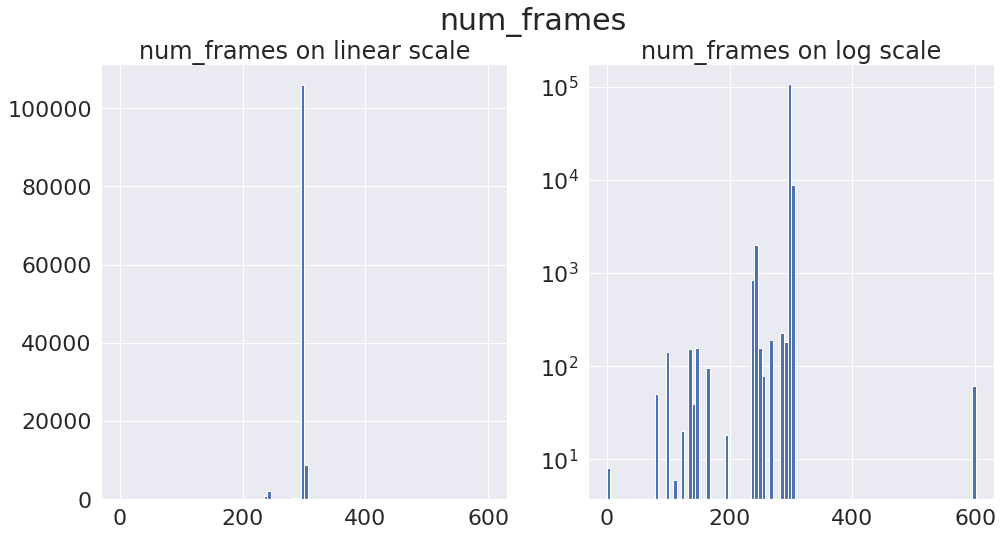

In [16]:
plot_hist(all_metadata, 'num_frames')

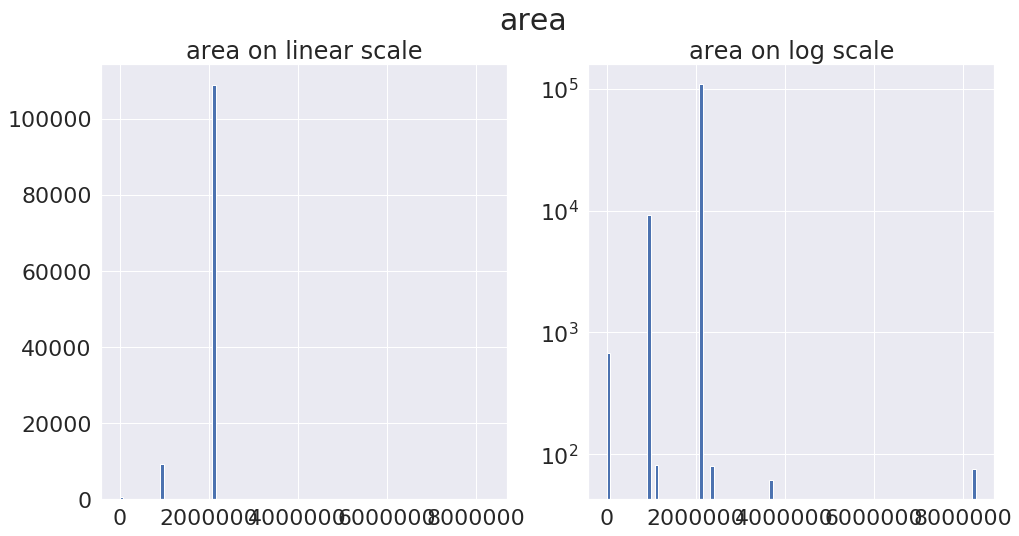

In [17]:
plot_hist(all_metadata, 'area')

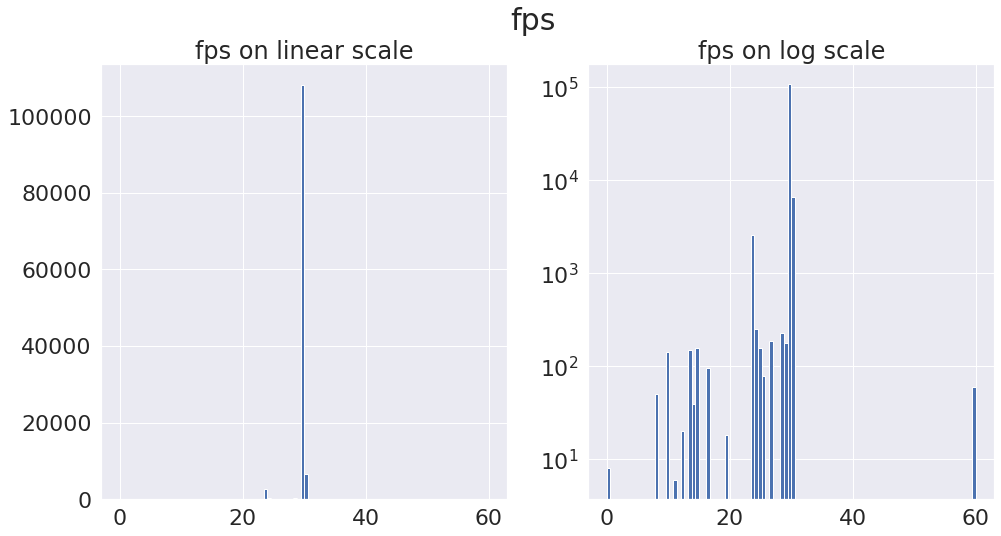

In [18]:
plot_hist(all_metadata, 'fps')

### Create dataset

So now we have a map from original files to their corresponding deep fakes. We'd like to create a roughly balanced dataset with this so for each original file, we'll select two deep fakes.

In [19]:
original_metadata = all_metadata.loc[all_metadata['label'] == 'REAL']
len(original_metadata)

19154

In [20]:
original_metadata.head()

,fname,label,split,original,directory,width,height,area,fps,num_frames
1,vpmyeepbep.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9687,300.0
2,fzvpbrzssi.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9690,300.0
11,syxobtuucp.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9690,300.0
26,dhjnjkzuhq.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9689,300.0
27,xcruhaccxc.mp4,REAL,train,NaN,../data/dfdc_train_part_0,1080.0,1920.0,2073600.0,29.9690,300.0


In [21]:
train_metadata = original_metadata.loc[~original_metadata['directory'].isin(['../data/dfdc_train_part_47', '../data/dfdc_train_part_48', '../data/dfdc_train_part_49'])]
valid_metadata = original_metadata.loc[ original_metadata['directory'].isin(['../data/dfdc_train_part_47','../data/dfdc_train_part_48', '../data/dfdc_train_part_49'])]

In [22]:
train_metadata.shape, valid_metadata.shape

((17795, 10), (1359, 10))

In [23]:
# Find all original videos and choose two deep fakes for them
videos_to_process = []

for original, fakes in tqdm(original_to_fake_lookup.items()):
    original_with_fakes = [original]
    #Select two fakes at random
    np.random.shuffle(fakes)
    original_with_fakes.append(fakes[0])
    
    # Some deep fakes have only one video
    if len(fakes) > 1:
        original_with_fakes.append(fakes[1])
    
    videos_to_process.append(original_with_fakes)

In [24]:
def get_detections(detector, frames):

    all_dets = []
    # frames = read_random_frames(video_path, num_frames=num_frames)
    # TODO: Handle errors reading frames
    height, width, _ = frames[0].shape

    if height == width:
        # If it's a square video just predict on it directly
        dets = detector.detect_on_multiple_frames(frames)
        return dets

    elif height > width:
        # If it's a vertical video, take three crops
        top = frames[:, :width, :, :]
        center = frames[:, height // 2 - width // 2:height // 2 + width // 2, :, :]
        bottom = frames[:, -width:, :, :]

        top_dets = detector.detect_on_multiple_frames(top)
        center_dets = detector.detect_on_multiple_frames(center)
        bottom_dets = detector.detect_on_multiple_frames(bottom)

        for t_dets, c_dets, b_dets in zip(top_dets, center_dets, bottom_dets):
            frame_dets = []

            # Add top detections for this frame
            for x_min, y_min, x_max, y_max, prob in t_dets:
                frame_dets.append([float(x_min), float(y_min), float(x_max), float(y_max), float(prob)])

            # Add center detections for this frame
            # Make sure to account for vertical shift
            for x_min, y_min, x_max, y_max, prob in c_dets:
                offset = height // 2 - width // 2
                frame_dets.append([float(x_min), float(y_min + offset), float(x_max), float(y_max + offset), float(prob)])

            # Add bottom detections for this frame
            # Make sure to account for vertical shift
            for x_min, y_min, x_max, y_max, prob in b_dets:
                offset = height - width
                frame_dets.append([float(x_min), float(y_min + offset), float(x_max), float(y_max + offset), float(prob)])

            frame_dets = np.array(frame_dets)
            if len(frame_dets) > 0:
                inds = nms(frame_dets, 0.5)
                frame_dets = frame_dets[inds]

            all_dets.append(frame_dets)

    elif height < width:
        # If it's a horizontal video, take three crops
        left = frames[:, :, :height, :]
        center = frames[:, :, width // 2 - height // 2:width // 2 + height // 2, :]
        right = frames[:, :, -height:, :]

        left_dets = detector.detect_on_multiple_frames(left)
        center_dets = detector.detect_on_multiple_frames(center)
        right_dets = detector.detect_on_multiple_frames(right)

        for l_dets, c_dets, r_dets in zip(left_dets, center_dets, right_dets):
            frame_dets = []

            # Add left detections for this frame
            for x_min, y_min, x_max, y_max, prob in l_dets:
                frame_dets.append([float(x_min), float(y_min), float(x_max), float(y_max), float(prob)])

            # Add center detections for this frame
            # Make sure to account for left shift
            for x_min, y_min, x_max, y_max, prob in c_dets:
                offset = width // 2 - height // 2
                frame_dets.append([float(x_min + offset), float(y_min), float(x_max + offset), float(y_max), float(prob)])

            # Add right detections for this frame
            # Make sure to account for left shift
            for x_min, y_min, x_max, y_max, prob in r_dets:
                offset = width - height
                frame_dets.append([float(x_min + offset), float(y_min), float(x_max + offset), float(y_max), float(prob)])

            frame_dets = np.array(frame_dets)

            if len(frame_dets) > 0:
                inds = nms(frame_dets, 0.5)
                frame_dets = frame_dets[inds]

            all_dets.append(frame_dets)

    return all_dets


In [25]:
too_many_faces = []
no_faces = []

os.makedirs('../data/train', exist_ok=True)
os.makedirs('../data/valid', exist_ok=True)

detector = EasyBlazeFace()

for videos in tqdm(videos_to_process):
    
    for video_fname in videos:
            
        video_info = all_metadata.loc[all_metadata['fname'] == video_fname].iloc[0]
        video_path = video_info['directory'] + "/" + video_fname
        
        # Get label
        label = video_info['label']
        # Get original
        original = video_info['original'] 
        if type(original) == float:
            original = video_fname
        
        is_train = train_metadata['fname'].str.contains(original).any()
        
        try:
            frames = read_random_frames(video_path, num_frames=2)        
            frames_detections = get_detections(detector, frames)

            for i in range(len(frames)):

                detections = frames_detections[i]

                #plot_detections(frames[i], detections)

                if len(detections) <= 0:
                    no_faces.append(video_path)
                    if len(no_faces) % 100 == 0:
                        print("No faces: {}".format(len(no_faces)))
                elif len(detections) > 1:
                    too_many_faces.append(video_path)
                    if len(too_many_faces) % 500 == 0:
                        print("Too many faces: {}".format(len(too_many_faces)))
                else:
                    # Only one detection
                    x_min, y_min, x_max, y_max, _ = detections[0]
                    frame = frames[i]
                    cropped_face = frame[int(y_min):int(y_max), int(x_min):int(x_max)]

                    path = Path("../data/")

                    # Is this train or valid?
                    if is_train == True:
                        path = path/'train'
                    else:
                        path = path/'valid'

                    path = path/(video_fname + '_' + str(i) + '_' + label + '.jpg')

                    im = Image.fromarray(cropped_face)

                    im.save(path)

                    # TODO: Save cropped face to disk
                    # plt.imshow(cropped_face)
                    # plt.show()
        except Exception as e:
            print("Problem on: ", video_path)
            print(e)
  

Too many faces: 500
No faces: 100
No faces: 200
Too many faces: 1000
No faces: 300
Too many faces: 1500
No faces: 400
No faces: 500
No faces: 600
Too many faces: 2000
No faces: 700
Too many faces: 2500
Too many faces: 3000
No faces: 800
No faces: 900
Too many faces: 3500
No faces: 1000
No faces: 1100
Too many faces: 4000
No faces: 1200
No faces: 1300
Too many faces: 4500
No faces: 1400
Too many faces: 5000
No faces: 1500
Problem on:  ../data/dfdc_train_part_18/wipjitfmta.mp4
OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'

Problem on:  ../data/dfdc_train_part_18/wpuxmawbkj.mp4
OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'

Too many fa